### 基于seq2seq的时序预测

seq2seq结构：https://blog.csdn.net/weixin_33698043/article/details/90304107

seq2seq介绍：https://mp.weixin.qq.com/s/Wdj_GW8xbBQZN2UCl8O3fQ

seq2seq用于时序预测：https://github.com/LukeTonin/keras-seq-2-seq-signal-prediction 

Attention: https://blog.csdn.net/qq_34862636/article/details/103472650?utm_medium=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-7.control&dist_request_id=835d2aff-2961-4615-be4b-d44869a694d3&depth_1-utm_source=distribute.pc_relevant.none-task-blog-BlogCommendFromMachineLearnPai2-7.control

seq2seq+attention: https://zhuanlan.zhihu.com/p/37290775

In [1]:
import pandas as pd
import xlrd
import numpy as np
import matplotlib.pyplot as plt
import datetime, time
import math
import numpy
from keras.layers import LSTM, RNN, GRU, SimpleRNN, Dense, Dropout, Embedding, Input, GRUCell, Reshape
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import os

numpy.random.seed(2021)

Using TensorFlow backend.
/Users/zhangyingji/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/zhangyingji/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/zhangyingji/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/zhangyingji/opt/ana

In [2]:
df = pd.read_excel('./final_data.xlsx')

label = list(df['label'])
dataset = np.array(df[[i for i in range(51)]])

dataset.shape

(4284, 51)

### 1. 时序数据分析

三种时间序列：纯随机序列（白噪声序列），平稳非白噪声序列，非平稳序列。

判断白噪声序列方法：1. 自相关图，2. Ljung-Box test

/Users/zhangyingji/opt/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/utils.py:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure()


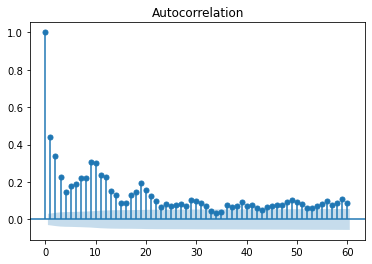

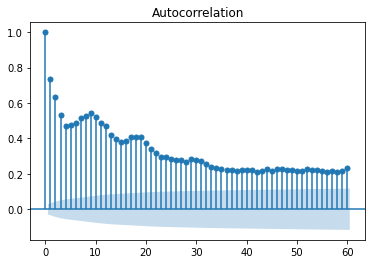

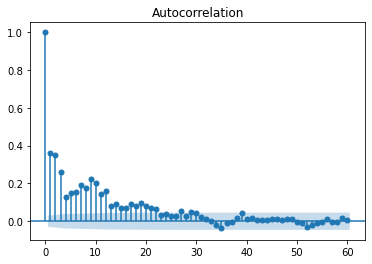

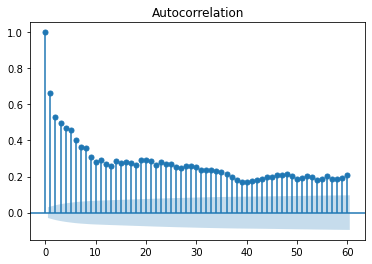

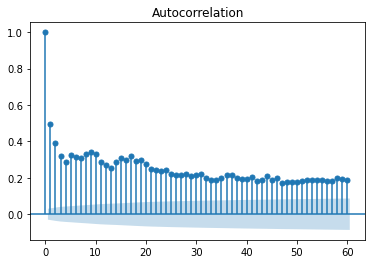

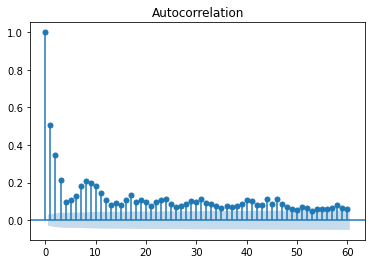

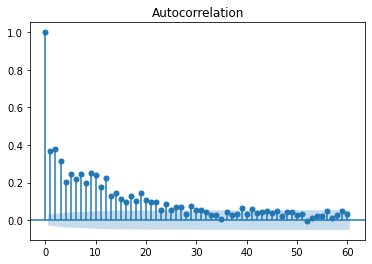

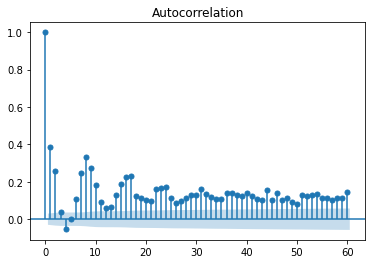

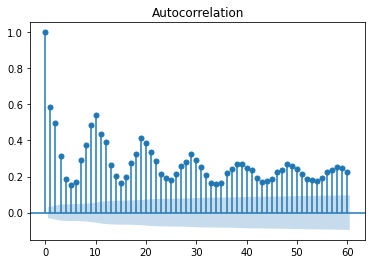

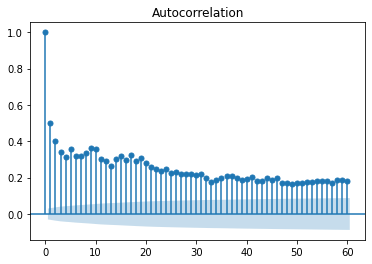

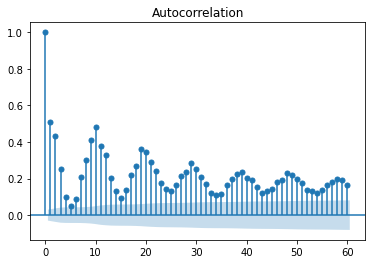

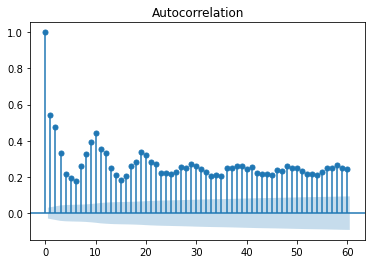

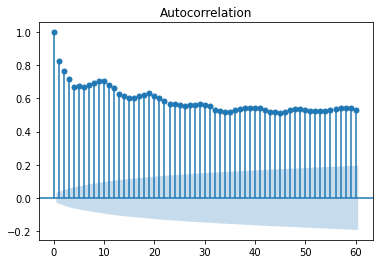

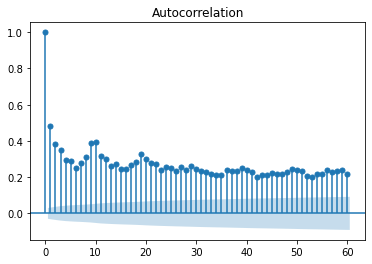

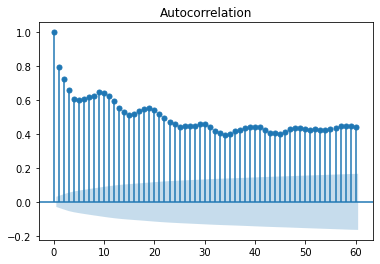

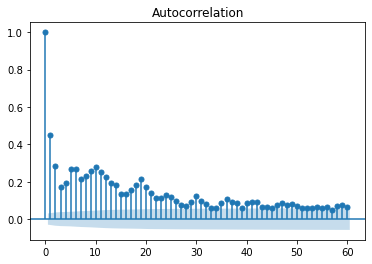

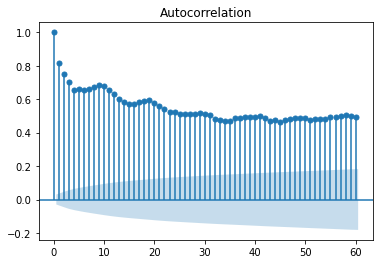

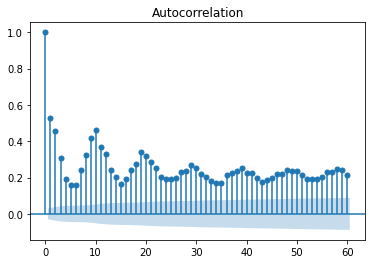

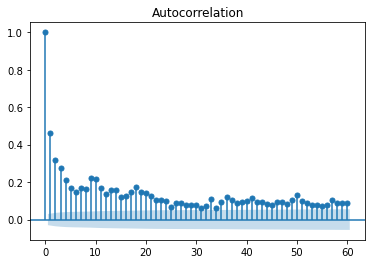

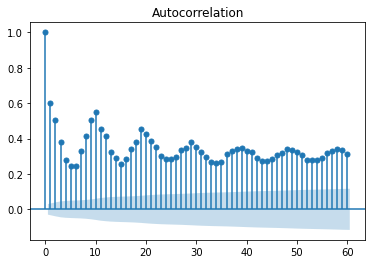

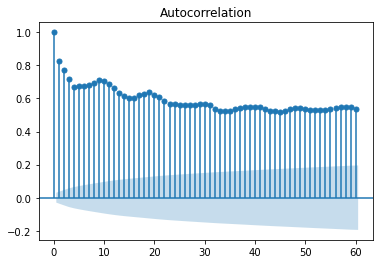

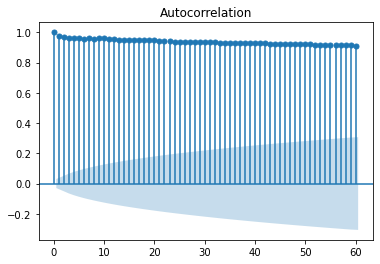

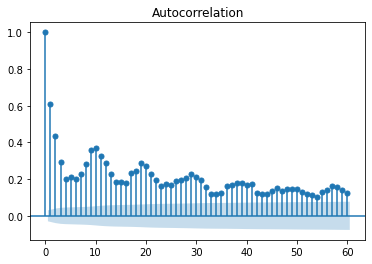

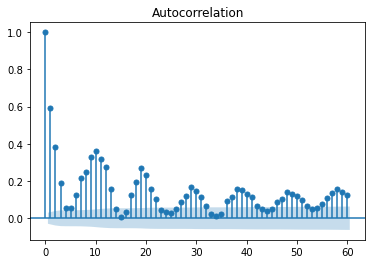

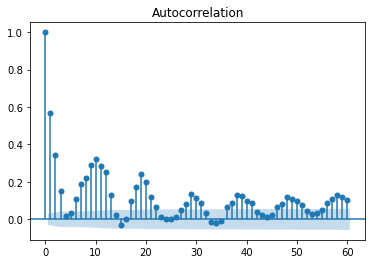

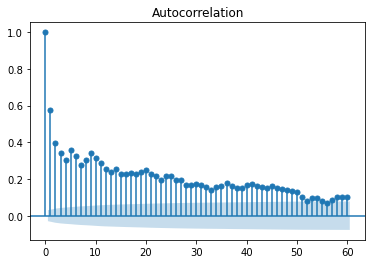

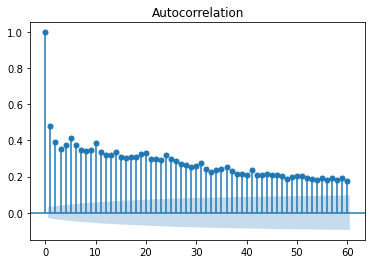

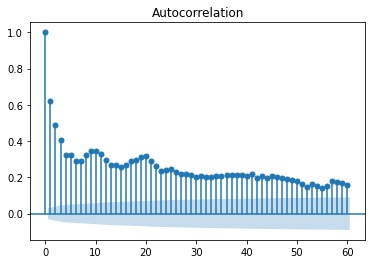

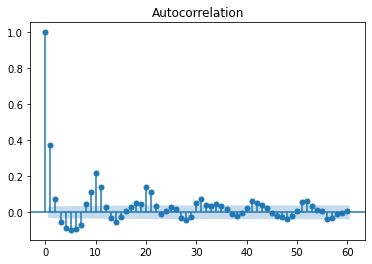

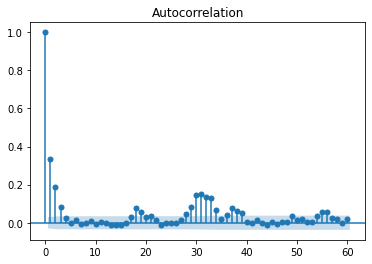

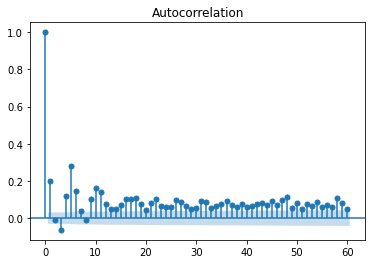

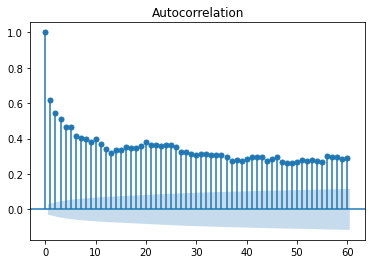

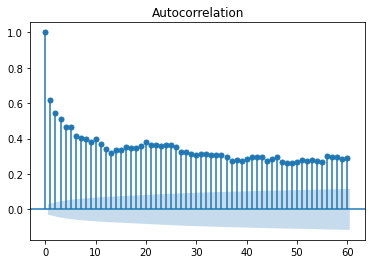

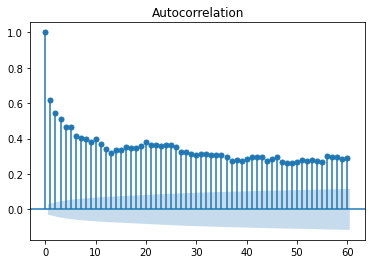

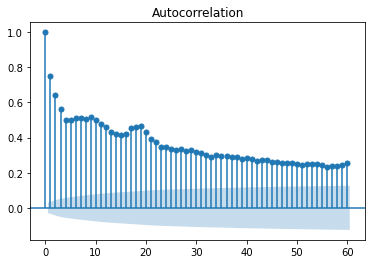

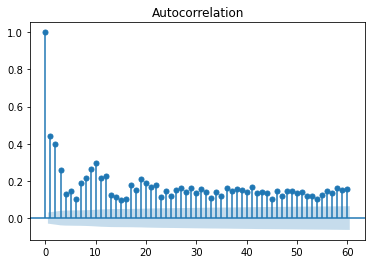

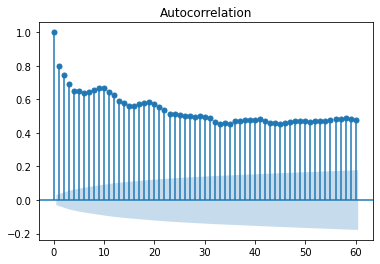

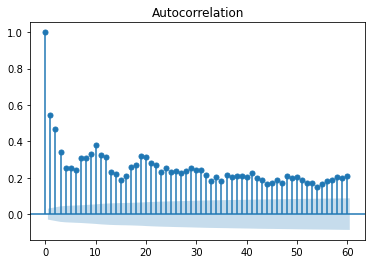

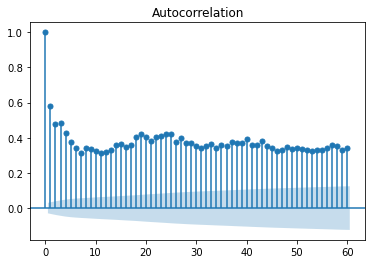

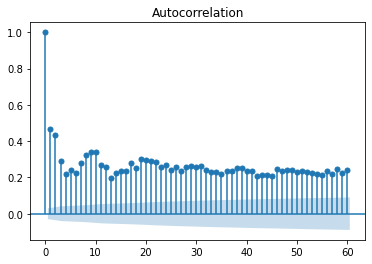

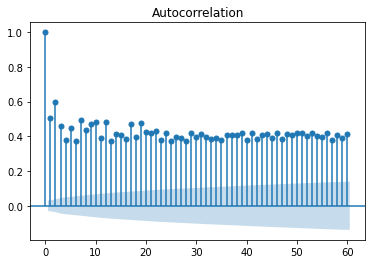

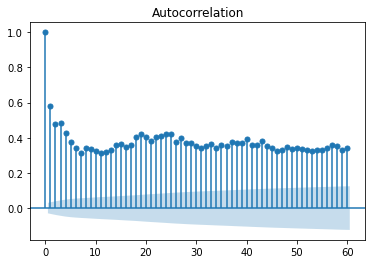

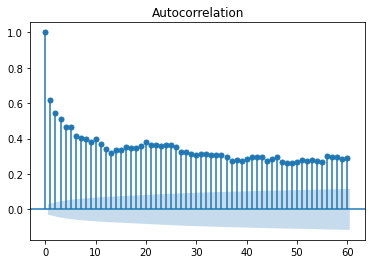

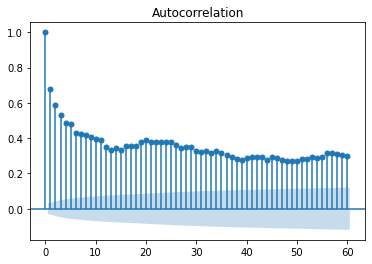

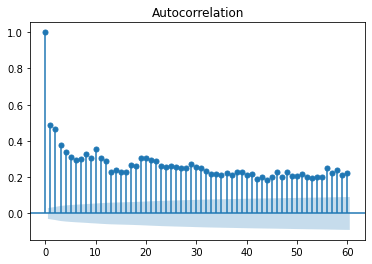

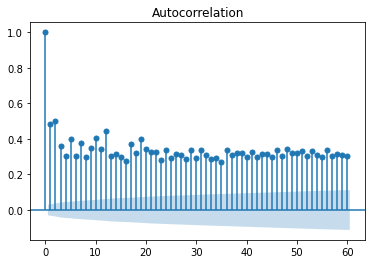

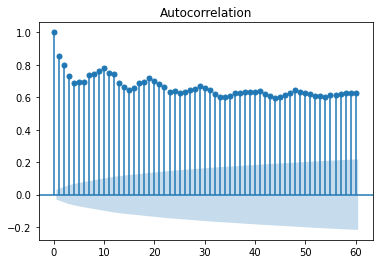

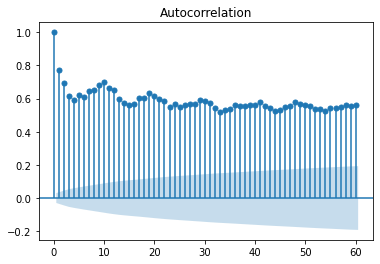

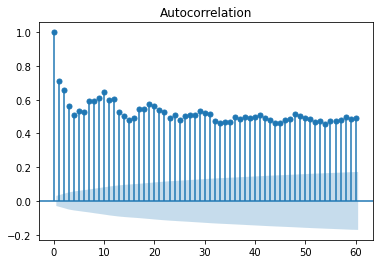

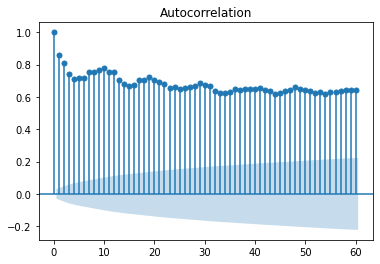

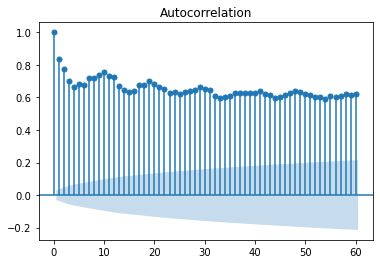

In [42]:
"""
如果有超过5%的竖线超过两条蓝色虚线，则这个时间序列可能不是白噪声。
"""
import statsmodels.api as sm
for i in range(51):
    fig = sm.graphics.tsa.plot_acf(dataset[:, i], lags=60)

In [51]:
"""
Ljung-Box test: p-value > 0.05 则为白噪声。
"""
from statsmodels.stats.diagnostic import acorr_ljungbox

for i in range(51):
    p = acorr_ljungbox(dataset[:, i], lags = 60, boxpierce=False) 
    print(p[1])

[1.53387014e-184 2.90267043e-288 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
[0. 0. 0. 0. 0. 0. 0. 0.

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


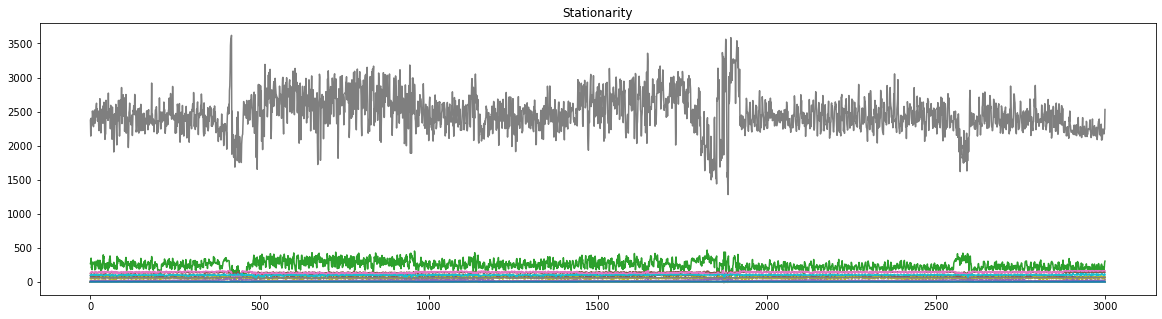

In [39]:
"""
观察数据平稳性：直观上看当数据没有明显的模式特征的话（趋势性、季节性），我们认为它是平稳的。

另一方面，我们也可以通过自相关图来进行检验：

对于平稳时间序列，其自相关图一般随着阶数的递增，自相关系统会迅速衰减至0附近，而非平稳时间序列则可能存在先减后增或者周期性波动等变动。
"""
plt.figure(figsize=(20, 5))
plt.title('Stationarity')
for i in range(51):
    plt.plot(dataset[:3000, i])

In [52]:
"""
结论：1. 每个特征为非随机序列，可以使用时序模型。2. 某些特征自相关图存在周期性波动，序列平稳性较差。
"""

'\n结论：1. 每个特征为非随机序列，可以使用时序模型。2. 某些特征自相关图存在周期性波动，序列平稳性较差。\n'

### 2. 时序预测三种方法：

1. 传统时序建模方法
>* 平稳时间序列分析: 自回归（AR），移动平均（MA），自回归移动平均（ARMA） 
>
>* 非平稳时序分析: 差分自回归移动平均（ARIMA）

2. 传统机器学习
3. 深度学习（RNN）


传统时序建模方法: https://blog.csdn.net/FrankieHello/article/details/80883147

### 2.1 自回归

In [126]:
import pandas as pd
import numpy as np
from statsmodels.tsa.ar_model import AR
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as MSE

i = 0
train, test = dataset[:3000, i], dataset[3000:3200, i]

def train_AR(data):
    model_fit = AR(train).fit()
    params = model_fit.params
    p = model_fit.k_ar
    return params, p

params, p = train_AR(train)

1.236986339322212


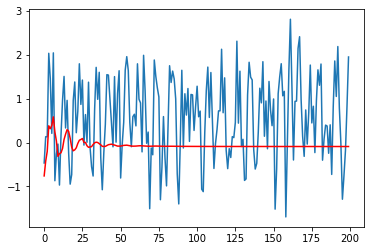

In [127]:
history = train[-p:]
history = np.hstack(history).tolist()
test = np.hstack(test).tolist()

predictions = []
for t in range(len(test)):
    lag = history[-p:]
    yhat = params[0]
    for i in range(p):
        yhat += params[i+1] * lag[p-1-i]
        
    predictions.append(yhat)
    obs = test[t]
    history.append(yhat)
    
print(np.mean((np.array(test) - np.array(predictions))**2))
plt.plot(test)
plt.plot(predictions, color='r')
plt.show()

### 2.2 深度学习方法 

多层GRU与seq2seq用于时序预测对比 **数据不足导致过拟合**

In [3]:
interval = 60
tr_size = 3200
te_size = 3324

feature_index = 0 # 取第一个特征为例

dataset_x = np.array([ dataset[:, feature_index][i:i+interval] for i in range(0, dataset.shape[0]-interval*2)])
dataset_y = np.array([ dataset[:, feature_index][i:i+interval] for i in range(interval, dataset.shape[0]-interval)])
    
train_x, test_x = dataset_x[:tr_size], dataset_x[te_size:]

train_y, test_y = dataset_y[:tr_size], dataset_y[te_size:]    

In [74]:
"""
seq2seq 串联结构 基于单个特征的时序预测：输入数据为当前一小时每个特征的时序值，输出为每个特征下一小时的时序值。
"""
def feature_based_seq2seq():
    encoder_input = Input(shape=(1,interval))
    encoder_output = GRU(100, input_shape=(1, interval), return_sequences=True, return_state=True)(encoder_input)

    decoder_input = Input(shape=(1,interval))
    decoder_output = GRU(100, input_shape=(1, interval), return_sequences=True, return_state=True)(decoder_input, initial_state=encoder_output[1:])
    temp_output = Dense(80)(decoder_output[0])
    final_output = Dense(interval)(Dropout(0.2)(temp_output))
    
    seq2seq_model = Model(inputs=[encoder_input, decoder_input], outputs=final_output)
    seq2seq_model.compile(optimizer='adam', loss='mean_squared_error')
    return seq2seq_model

In [75]:
"""
decoder有两种输入 训练阶段：输入为label横移一位（teacher forcing 效果好坏有待考证），预测阶段：输入为上一时刻的输出。
"""
# verbose=0, 1, 2 显示训练过程。

model = feature_based_seq2seq()
histroy = model.fit([train_x.reshape((train_x.shape[0], 1, train_x.shape[1])), np.ones((train_x.shape[0], 1, train_x.shape[1]))], train_y.reshape((train_y.shape[0], 1, train_y.shape[1])), 
                    epochs=200, 
                    verbose = 1, 
                    validation_data=([test_x.reshape((test_x.shape[0], 1, test_x.shape[1])), np.ones((test_x.shape[0], 1, test_x.shape[1]))], test_y.reshape((test_y.shape[0], 1, test_y.shape[1]))))



Train on 2200 samples, validate on 800 samples
Epoch 1/200
2200/2200 [==============================] - 5s 2ms/step - loss: 1.1260 - val_loss: 0.7868
Epoch 2/200
2200/2200 [==============================] - 1s 302us/step - loss: 1.0608 - val_loss: 0.7791
Epoch 3/200
2200/2200 [==============================] - 1s 307us/step - loss: 1.0338 - val_loss: 0.7823
Epoch 4/200
2200/2200 [==============================] - 1s 318us/step - loss: 1.0110 - val_loss: 0.7803
Epoch 5/200
2200/2200 [==============================] - 1s 313us/step - loss: 0.9877 - val_loss: 0.7747
Epoch 6/200
2200/2200 [==============================] - 1s 312us/step - loss: 0.9649 - val_loss: 0.7856
Epoch 7/200
2200/2200 [==============================] - 1s 315us/step - loss: 0.9468 - val_loss: 0.7946
Epoch 8/200
2200/2200 [==============================] - 1s 321us/step - loss: 0.9304 - val_loss: 0.7945
Epoch 9/200
2200/2200 [==============================] - 1s 342us/step - loss: 0.9147 - val_loss: 0.7907
Epoch 10/2

KeyboardInterrupt: 

In [61]:
from sklearn.metrics import mean_squared_error
# 训练集预测情况
tr_y = model.predict([train_x.reshape((train_x.shape[0], 1, train_x.shape[1])), np.ones((train_x.shape[0], 1, train_x.shape[1]))])
tr_pred_y = tr_y.reshape((-1, interval))

# 测试集预测情况
te_y = model.predict([test_x.reshape((test_x.shape[0], 1, test_x.shape[1])), np.ones((test_x.shape[0], 1, test_x.shape[1]))])
te_pred_y = te_y.reshape((-1, interval))

index, small_mse = 0, 100
average_mse = 0
for i in range(test_y.shape[0]):
    mse = mean_squared_error(test_y[i], te_pred_y[i], squared=False)
    average_mse += mse
    if mse < small_mse: 
        small_mse = mse 
        index = i
    
print("small mse index: ", index)
print("average mse: ", average_mse/test_y.shape[0])

small mse index:  255
average mse:  1.4029719952734185


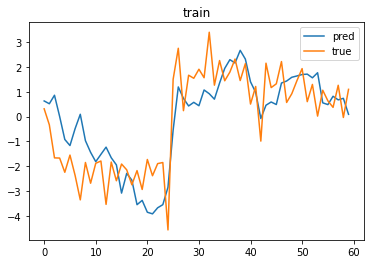

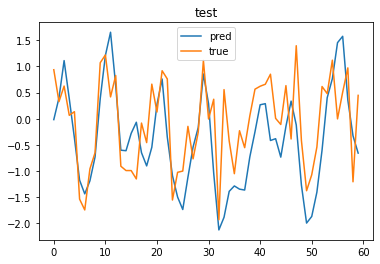

In [62]:
"""
选择mse最小的展示
"""
plt.figure()
plt.title("train")
plt.plot(tr_pred_y[-1], label='pred')
plt.plot(train_y[-1], label='true')
plt.legend()


plt.figure()
plt.title("test")
plt.plot(te_pred_y[index], label='pred')
plt.plot(test_y[index], label='true')
plt.legend()

In [31]:
"""
多层GRU结构
"""
def feature_based_GRU():
    model_input = Input(shape=(1,interval))
    temp_output = GRU(200, return_sequences=True, return_state=False, dropout=0.5)(model_input)
    temp_output1 = GRU(200, return_sequences=False, return_state=True, dropout=0.5)(temp_output)
    final_output = Dense(interval)(temp_output)
    
    model = Model(inputs=model_input, outputs=final_output)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

model1 = feature_based_GRU()

In [34]:
histroy = model1.fit(train_x.reshape((train_x.shape[0], 1, train_x.shape[1])), train_y.reshape((train_y.shape[0], 1, train_y.shape[1])), epochs=200, verbose=1,
                    validation_data=(test_x.reshape((test_x.shape[0], 1, test_x.shape[1])), test_y.reshape((test_y.shape[0], 1, test_y.shape[1]))),
                    )


Train on 3200 samples, validate on 840 samples
Epoch 1/200
3200/3200 [==============================] - 3s 953us/step - loss: 1.0856 - val_loss: 0.5756
Epoch 2/200
3200/3200 [==============================] - 1s 297us/step - loss: 1.0338 - val_loss: 0.5746
Epoch 3/200
3200/3200 [==============================] - 1s 298us/step - loss: 1.0222 - val_loss: 0.5751
Epoch 4/200
3200/3200 [==============================] - 1s 299us/step - loss: 1.0148 - val_loss: 0.5750
Epoch 5/200
3200/3200 [==============================] - 1s 297us/step - loss: 1.0075 - val_loss: 0.5751
Epoch 6/200
3200/3200 [==============================] - 1s 306us/step - loss: 1.0018 - val_loss: 0.5758
Epoch 7/200
1728/3200 [===============>..............] - ETA: 0s - loss: 0.9757

KeyboardInterrupt: 

In [66]:
from sklearn.metrics import mean_squared_error

# 训练集预测情况
tr_y = model1.predict(train_x.reshape((train_x.shape[0], 1, train_x.shape[1])))
tr_pred_y = tr_y.reshape((-1, interval))

# 测试集预测情况
te_y = model1.predict(test_x.reshape((test_x.shape[0], 1, test_x.shape[1])))
te_pred_y = te_y.reshape((-1, interval))

index, small_mse = 0, 100
average_mse = 0
for i in range(test_y.shape[0]):
    mse = mean_squared_error(test_y[i], te_pred_y[i], squared=False)
    average_mse += mse
    if mse < small_mse: 
        small_mse = mse 
        index = i
    
print("small mse index: ", index)
print("average mse: ", average_mse/test_y.shape[0])

small mse index:  450
average mse:  1.243420722299195


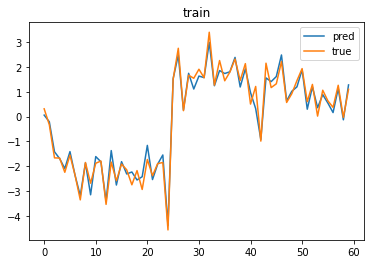

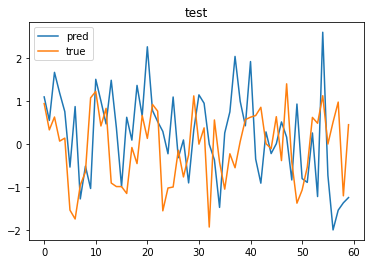

In [67]:
plt.figure()
plt.title("train")
plt.plot(tr_pred_y[-1], label='pred')
plt.plot(train_y[-1], label='true')
plt.legend()

plt.figure()
plt.title("test")
plt.plot(te_pred_y[255], label='pred')
plt.plot(test_y[255], label='true')
plt.legend()

In [74]:
"""
基于全部特征
"""
# 基于全部特征的模型结构，输入数据为当前一小时全部特征的时序值，输出为0/1。（效果不好）
# Embedding层的作用是look-up table 查找索引对应的特征向量。
# 数据集转换 由于需要Embedding层，需要将数据转换为索引形式。

dataset_x = np.array([ dataset[i:i+interval, :] for i in range(0, dataset.shape[0]-interval*2)])
dataset_y = np.array([ label[i:i+interval] for i in range(interval, len(label)-interval)])

key, embedding_matrix, index_dataset = 0, list(), list()

for i in range(dataset_x.shape[0]):
    temp = []
    for j in range(dataset_x.shape[1]):
        embedding_matrix.append(dataset_x[i, j, :])
        temp.append(key)
        key+=1
    
    index_dataset.append(temp)

final_index_dataset = np.array(index_dataset)
vocab_len = key+1
embedding_matrix = np.array(embedding_matrix)
tr_size = 3240
te_size = 3324 
train_x, test_x = final_index_dataset[:tr_size], final_index_dataset[te_size:]
train_y, test_y = dataset_y[:tr_size], dataset_y[te_size:]

In [77]:
# seq2seq 结构4 GRU串联

def all_features_seq2seq():
    # encoder
    encoder_input = Input(shape=(None,))
    embed_vec = Embedding(embedding_matrix.shape[0], 51, input_length=60, trainable=False, weights=[embedding_matrix])(encoder_input)
    encoder_output = GRU(100, return_sequences=True, return_state=True)(embed_vec)
    # decoder
    decoder_input = Input(shape=(1,60))
    decoder_output = GRU(100, input_shape=(1, 60), return_sequences=True, return_state=True)(decoder_input, initial_state=encoder_output[1:])
    final_output = Dense(60, activation='sigmoid')(decoder_output[0])

    seq2seq_model = Model(inputs=[encoder_input, decoder_input], outputs=final_output)
    seq2seq_model.compile(optimizer='adam', loss='binary_crossentropy')
    
    return seq2seq_model

In [79]:
model1 = all_features_seq2seq()
history = model1.fit([train_x, np.zeros((train_x.shape[0], 1, 60))], train_y.reshape((-1, 1, 60)), epochs=300, verbose = 1)
pred = model1.predict([test_x, np.zeros((test_x.shape[0], 1, 60))])

Epoch 1/300
3240/3240 [==============================] - 13s 4ms/step - loss: 0.6676: 2
Epoch 2/300
3240/3240 [==============================] - 11s 3ms/step - loss: 0.6577
Epoch 3/300
3240/3240 [==============================] - 11s 3ms/step - loss: 0.6529
Epoch 4/300
3240/3240 [==============================] - 11s 3ms/step - loss: 0.6493
Epoch 5/300
3240/3240 [==============================] - 11s 3ms/step - loss: 0.6515
Epoch 6/300
3240/3240 [==============================] - 12s 4ms/step - loss: 0.6448
Epoch 7/300
3240/3240 [==============================] - 11s 4ms/step - loss: 0.6439
Epoch 8/300
3240/3240 [==============================] - 11s 3ms/step - loss: 0.6436
Epoch 9/300
3240/3240 [==============================] - 11s 4ms/step - loss: 0.6440
Epoch 10/300
3240/3240 [==============================] - 11s 4ms/step - loss: 0.6445
Epoch 11/300
3240/3240 [==============================] - 11s 4ms/step - loss: 0.6453
Epoch 12/300
1952/3240 [=================>............] - ET

KeyboardInterrupt: 